In [1]:
import os
import csv
import math
import bert
import random
import sklearn
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

%matplotlib inline
tf.__version__

C:\Users\kwon\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


'2.3.0'

#### load data

In [2]:
train = pd.read_csv('./data/train.csv').fillna('')
train['median_relevance'] = train['median_relevance']-1
test = pd.read_csv('./data/test.csv').fillna('')
train = train[['query', 'product_title', 'median_relevance']]

In [3]:
model_name = 'uncased_L-4_H-256_A-4'
model_dir = '.models\\uncased_L-4_H-256_A-4\\' + model_name
model_ckpt = os.path.join(model_dir, "bert_model.ckpt")
model_config = os.path.join(model_dir, "bert_config.json")

bert.bert_tokenization.validate_case_matches_checkpoint(do_lower_case=True, init_checkpoint=model_ckpt)
vocab_file = os.path.join(model_dir, "vocab.txt")
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case=True)

#### data processing

In [6]:
class Data(object):
    DATA_COLUMN1 = "query"
    DATA_COLUMN2 = "product_title"
    LABEL_COLUMN = "median_relevance"

    def __init__(self, tokenizer, train, test):
        self.tokenizer = tokenizer
        self.max_seq_len = 0 
        
        train, dev = train_test_split(train, test_size=0.2)
        
        ((self.train_x, self.train_y), 
         (self.dev_x, self.dev_y),
         (self.test_x, self.test_y))= map(self._prepare, [train, dev, test])
        
        ((self.train_x, self.train_x_token_types), 
         (self.dev_x, self.dev_x_token_types),
         (self.test_x, self.test_x_token_types)) = map(self._pad, [self.train_x, self.dev_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text1, text2 = row[Data.DATA_COLUMN1], row[Data.DATA_COLUMN2]
                tokens = ["[CLS]"] + self.tokenizer.tokenize(text1) + ["[SEP]"] + self.tokenizer.tokenize(text2) + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                if self.max_seq_len < len(token_ids):
                    self.max_seq_len = len(token_ids)   
                x.append(token_ids)
                try:
                    label = row[Data.LABEL_COLUMN]
                    y.append(int(label))
                    pbar.update()
                except:
                    pbar.update()
        return np.array(x), np.array(y)
    
    def _pad(self, ids):
        x, t = [], []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            token_type_ids = [0] * (input_ids.index(102)+1) + [1] * (len(input_ids) - input_ids.index(102)-1)
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            token_type_ids = token_type_ids + [0] * (87 - len(token_type_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)

In [7]:
data = Data(tokenizer, train, test)

#### load model

In [8]:
bert_params = bert.params_from_pretrained_ckpt(model_dir)
bert_layer = bert.BertModelLayer.from_params(bert_params, name="bert")

input_ids = tf.keras.layers.Input(shape=(data.max_seq_len,), dtype='int32', name="input_ids")
token_type_ids = tf.keras.layers.Input(shape=(data.max_seq_len,), dtype='int32', name="token_type_ids")

output = bert_layer([input_ids, token_type_ids])

cls_out = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :], name='CLSTokenSliceLayer')(output)
logits = tf.keras.layers.Dense(units=4, activation='softmax')(cls_out)

model = tf.keras.models.Model(inputs=[input_ids, token_type_ids], outputs=logits)
model.build(input_shape=[(None, data.max_seq_len), (None, data.max_seq_len)])

In [9]:
# model.load_weights("./model_weights/class_weight_cross_entropy.h5") 
bert.load_bert_weights(bert_layer, model_ckpt)  
model.summary()

Done loading 69 BERT weights from: .models\uncased_L-4_H-256_A-4\uncased_L-4_H-256_A-4\bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000025A42AD5308> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 87)]         0                                            
________________________________________________________

#### class_weight

In [10]:
value_count = collections.Counter(data.train_y)

class_weight_dict = {0:(1 / value_count[0])*(len(data.train_y))/4.0,
                     1:(1 / value_count[1])*(len(data.train_y))/4.0,
                     2:(1 / value_count[2])*(len(data.train_y))/4.0,
                     3:(1 / value_count[3])*(len(data.train_y))/4.0}
class_weight_dict

{0: 3.3523102310231025,
 1: 1.7274659863945578,
 2: 1.4763808139534884,
 3: 0.4089170692431562}

#### loss history callback

In [11]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[], 
                        'cohen_kappa':[], 'val_cohen_kappa':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['cohen_kappa'].append(logs.get('cohen_kappa'))

    def on_epoch_end(self, epoch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['val_cohen_kappa'].append(logs.get('val_cohen_kappa'))

#### Compile

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tfa.metrics.CohenKappa(num_classes=4, weightage='quadratic', sparse_labels=True)])

#### fit

In [13]:
total_epoch_count = 10
batch_size = 64
history = LossHistory()
model.fit(x=(data.train_x, data.train_x_token_types), y=data.train_y,
          validation_data=((data.dev_x, data.dev_x_token_types), data.dev_y),
          class_weight=class_weight_dict,
          batch_size=batch_size,
          shuffle=True,
          epochs=total_epoch_count,
          callbacks=[history,
                     tf.keras.callbacks.EarlyStopping(monitor='val_cohen_kappa', patience=3, restore_best_weights=True, mode='max')])

Epoch 1/10
254/254 [==============================] - 508s 2s/step - loss: 1.3178 - cohen_kappa: 0.2734 - val_loss: 1.0864 - val_cohen_kappa: 0.4590
Epoch 2/10
254/254 [==============================] - 506s 2s/step - loss: 1.1926 - cohen_kappa: 0.4272 - val_loss: 1.0280 - val_cohen_kappa: 0.5394
Epoch 3/10
254/254 [==============================] - 516s 2s/step - loss: 1.1330 - cohen_kappa: 0.4957 - val_loss: 1.0010 - val_cohen_kappa: 0.5601
Epoch 4/10
254/254 [==============================] - 507s 2s/step - loss: 1.0901 - cohen_kappa: 0.5384 - val_loss: 0.9799 - val_cohen_kappa: 0.5866
Epoch 5/10
254/254 [==============================] - 476s 2s/step - loss: 1.0457 - cohen_kappa: 0.5648 - val_loss: 1.0023 - val_cohen_kappa: 0.6055
Epoch 6/10
254/254 [==============================] - 687s 3s/step - loss: 1.0193 - cohen_kappa: 0.5864 - val_loss: 1.0710 - val_cohen_kappa: 0.5868
Epoch 7/10
254/254 [==============================] - 510s 2s/step - loss: 0.9976 - cohen_kappa: 0.6069 - 

In [14]:
# model.save_weights('./model_weights/class_weight_cross_entropy.h5', overwrite=True)

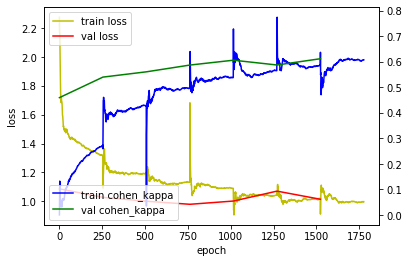

In [16]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()
xx = [i*(math.ceil(len(data.train_y)/(batch_size))) for i in range(len(history.history['val_loss']))]
# xx = np.linspace(0, len(history.history['loss']), len(history.history['loss'])//((len(data.train_y)//batch_size)+1), endpoint=False)
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(xx, history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['cohen_kappa'], 'b', label='train cohen_kappa')
acc_ax.plot(xx, history.history['val_cohen_kappa'], 'g', label='val cohen_kappa')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [17]:
# pred = model.predict(x=(data.test_x, data.test_x_token_types))
# pred = tf.math.argmax(pred, axis=1)
# pred = pred+1
# idx = test.id.values.astype(int)

# submission = pd.DataFrame({"id": idx, "prediction": pred})
# submission.to_csv("./submission.csv", index=False)